<a href="https://colab.research.google.com/github/MiaRosic/mtmap/blob/main/Fah_idioti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Svi potrebni paketi

In [ ]:
from google.colab import drive
import os
import scipy
from scipy.io import loadmat
import scipy.sparse
import scipy.linalg as la
from scipy.linalg import block_diag
from scipy.sparse.linalg import svds
import seaborn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from numpy.linalg import norm
import math

##Spajanje google drive-a i google colab-a



In [ ]:
drive.mount('/content/drive')
os.listdir("/content/drive/MyDrive/Colab Notebooks")

Mounted at /content/drive


['Ph300.mat', 'Ph500.mat', 'Fah_idioti.ipynb']

##Učitavanje podataka

In [ ]:
#MIA
ulazni_podaci3 = loadmat("/content/drive/MyDrive/Colab Notebooks/Ph300.mat")
ulazni_podaci5 = loadmat("/content/drive/MyDrive/Colab Notebooks/Ph500.mat")

#LARA
#ulazni_podaci3 = loadmat("/content/drive/My Drive/MTMAP/Ph300.mat")
#ulazni_podaci5 = loadmat("/content/drive/My Drive/MTMAP/Ph500.mat")

print (ulazni_podaci3.keys()) # zadnji u rječniku je Ph300 i to koristimo za daljnje učitavanje

Ph3 = ulazni_podaci3['Ph300']
ph3=Ph3.toarray()
data3 = pd.DataFrame(ph3)
Ph5 = ulazni_podaci5['Ph500']
ph5=Ph5.toarray()
data5 = pd.DataFrame(ph5)

dict_keys(['__header__', '__version__', '__globals__', 'Ph300'])


## Grafički prikaz matrica za podatke Ph300 i Ph500



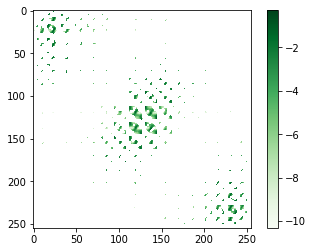

In [ ]:
plt.imshow(np.log(data3), cmap=plt.cm.get_cmap('Greens'))
#plt.title('Ph300')
plt.colorbar()
plt.show()

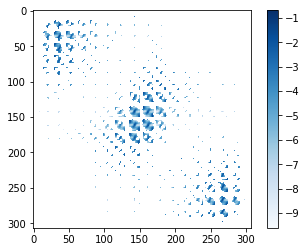

In [ ]:
plt.imshow(np.log(data5), cmap=plt.cm.get_cmap('Blues'))
#plt.title('Ph500')
plt.colorbar()
plt.show()

## Grafički prikaz svojstvenih vrijednosti (prvih 20 najvećih po apsolutnoj vrijednosti)

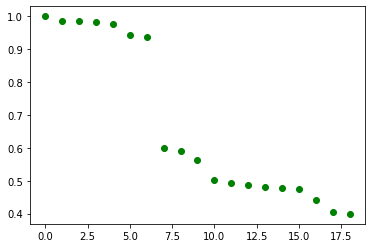

In [ ]:
value3, vector3 = la.eig(data3)
svrijed = -np.sort(-abs(value3))
plt.plot(svrijed[0:19], 'go')
#plt.title("Ph300")
plt.show()

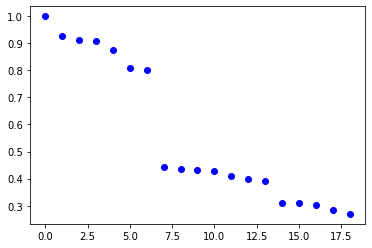

In [ ]:
value5, vector5 = la.eig(data5)
svrijed = -np.sort(-abs(value5))
plt.plot(svrijed[0:19], 'bo')
#plt.title("Ph500")
plt.show()

## SVD algoritam

*   B - matrica
*   thr - osjetljivost
*   a,b - indeksi koji govore koju podmatricu gledamo
*   dim - dimenzija početne matrice

In [ ]:
def SVD(B, thr, x=0, y=0 , dim=0):
  # postavljanje početnih vrijednosti:
  if dim==0:
    P=np.identity(len(B))
    dim=len(B)
    y=dim

  [U,S,V]=np.linalg.svd(B, 2) # ova funkcija računa samo prva dva sv.vektora 
  drugi_sv_vektor=U[:,1]
  indeksi_za_sortiranje=np.argsort(drugi_sv_vektor)
  sortirani_drugi_sv_vektor=np.sort(drugi_sv_vektor)

  # kreiranje permutacijske matrice
  dimB=len(drugi_sv_vektor)
  niz=np.arange(dimB) # [0, 1, ..., dimB]
  Ptilda = np.zeros((dimB, dimB), dtype=int)
  Ptilda[niz, indeksi_za_sortiranje]=1  

  # permutacijska matrica u početnoj dimenziji
  P1tilda=np.identity(dim)
  P1tilda[x:y, x:y]=Ptilda
  
  # permutiranje matrice B
  Btilda=np.dot(np.dot(Ptilda,B), np.transpose(Ptilda)) # Ptilda * B * Ptilda'

  # tražimo promjenu u predznaku
  ind=(np.where(np.diff(np.sign(sortirani_drugi_sv_vektor))))[0][0]

  # izdvajanje blokova B_1 i B_2
  B_1=Btilda[0:ind+1, 0:ind+1]
  B_2=Btilda[ind+1:dimB, ind+1:dimB]

  # računanje norme 1 matrica B_1 i B_2
  norma_1=(B_1.sum().sum())/ind
  norma_2=(B_2.sum().sum())/(dimB-ind)

  if ((norma_1 > thr) and (norma_2 > thr)):
    m1,n1,P1 = SVD(B_1, thr, x, x+ind+1, dim) # m1,2 je br. klastera, n1,2 dimenzije klastera
    m2,n2,P2 = SVD(B_2, thr, x+ind+1, y, dim) # P1,2 je trenutna matrica permutacije
    P=np.identity(dim)
    P[x:x+ind+1, x:x+ind+1] = P1[x:x+ind+1, x:x+ind+1]
    P[x+ind+1:y, x+ind+1:y] = P2[x+ind+1:y, x+ind+1:y]
    return m1+m2, np.append(n1,n2), np.dot(P, P1tilda)
  else:
    return 1, [dimB], P1tilda

## Algoritam za matricu sparivanja



In [ ]:
def matrica_sparivanja(A, n, m):
  W=np.zeros((m,m), dtype=np.double)
  a=-1
  for i in range(m):
    b=-1
    for j in range(m):
      podmatrica_od_A = A[(a+1):(a+n[i]+1),  (b+1):(b+n[j]+1)]
      velicina_na_W_i_j = (podmatrica_od_A.sum().sum()) / n[i] # 1-norma podmatrica
      W[i,j] = round(velicina_na_W_i_j, 4)
      b+=n[j]
    a+=n[i]
  return W

## Funkcija za crtanje permutiranih matrica sa granicama

In [ ]:
def crtanje_s_granicama(matrica, lista, boja, b):
  plt.imshow(matrica, cmap=plt.cm.get_cmap(boja))
  pocetak = -0.5
  for i in range (len(lista)):
    plt.plot([pocetak, pocetak], [pocetak, pocetak+lista[i]], b, lw=1)
    plt.plot([pocetak, pocetak+lista[i]], [pocetak+lista[i], pocetak+lista[i]], b, lw=1)
    plt.plot([pocetak+lista[i], pocetak], [pocetak, pocetak], b, lw=1)
    plt.plot([pocetak+lista[i], pocetak+lista[i]], [pocetak, pocetak+lista[i]], b, lw=1)
    pocetak+=lista[i]
  return

## Primjenjujemo algoritme na Ph300

In [ ]:
dimenzija3 = len(data3)
m3,n3,P3=SVD(B=data3, thr=0.5)
A3=np.dot(np.dot(P3,data3), np.transpose(P3))
W3=matrica_sparivanja(A3,n3,m3)
print(f"Matrica B tilda: \n{A3}\n")
print(f"Matrica sparivanja: \n{pd.DataFrame(W3)}\n")

Matrica B tilda: 
[[0.0045045  0.00075075 0.         ... 0.         0.         0.        ]
 [0.00292398 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.00561798 0.        ]
 [0.         0.         0.         ... 0.00149254 0.00597015 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]

Matrica sparivanja: 
        0       1       2       3       4       5       6
0  0.8027  0.0376  0.0023  0.0016  0.0361  0.0984  0.0212
1  0.0665  0.8178  0.1110  0.0000  0.0000  0.0047  0.0000
2  0.0020  0.0160  0.8478  0.0000  0.0016  0.0883  0.0443
3  0.0208  0.0000  0.0000  0.6590  0.2315  0.0117  0.0770
4  0.0671  0.0000  0.0011  0.0539  0.8141  0.0635  0.0004
5  0.0528  0.0008  0.0473  0.0145  0.1208  0.6691  0.0948
6  0.0108  0.0000  0.0303  0.0664  0.0076  0.0402  0.8448



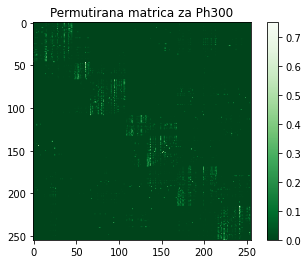

In [ ]:
plt.imshow(A3, cmap=plt.cm.get_cmap('Greens_r'))        # bez granica
#crtanje_s_granicama(A3, n3, "Greens_r", "g-") 
plt.title("Permutirana matrica za Ph300")
plt.colorbar()
plt.show()

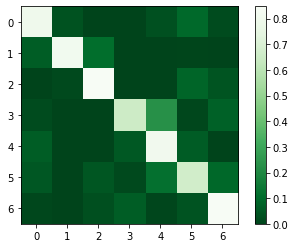

In [ ]:
plt.imshow(W3, cmap=plt.cm.get_cmap('Greens_r'))
#plt.title('Matrica sparivanja za Ph300')
plt.colorbar()
plt.show()

## Primjenjujemo algoritme na Ph500

In [ ]:
dimenzija5 = len(data5)
m5,n5,P5=SVD(B=data5, thr=0.5)
A5=np.dot(np.dot(P5,data5), np.transpose(P5))
W5=matrica_sparivanja(A5,n5,m5)
print(f"Matrica B tilda: \n{A5}\n")
print(f"Matrica sparivanja: \n{pd.DataFrame(W5)}\n")

Matrica B tilda: 
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00796813 0.00199203 ... 0.         0.         0.        ]
 [0.         0.00516529 0.00826446 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.15949486 0.05472404 0.01099158]
 [0.         0.         0.         ... 0.13692218 0.02282036 0.00789936]
 [0.         0.         0.         ... 0.03983051 0.01144068 0.00423729]]

Matrica sparivanja: 
        0       1       2       3       4       5
0  0.6150  0.1585  0.0244  0.1016  0.0288  0.0718
1  0.1191  0.4897  0.0765  0.0354  0.2204  0.0589
2  0.0213  0.1576  0.5290  0.1593  0.0980  0.0348
3  0.1336  0.0365  0.2507  0.5523  0.0228  0.0042
4  0.0348  0.1329  0.0123  0.0034  0.6725  0.1440
5  0.1411  0.1105  0.0206  0.0013  0.0716  0.6549



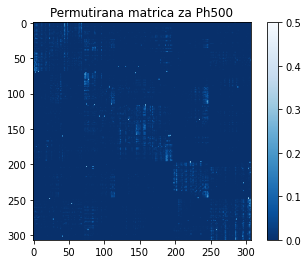

In [ ]:
plt.imshow(A5, cmap=plt.cm.get_cmap('Blues_r'))        # bez granica
#crtanje_s_granicama(A5, n5, "Blues_r", "b-")
plt.title("Permutirana matrica za Ph500")
plt.colorbar()
plt.show()

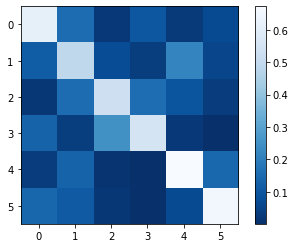

In [ ]:
plt.imshow(W5, cmap=plt.cm.get_cmap('Blues_r'))
#plt.title('Matrica sparivanja za Ph500')
plt.colorbar()
plt.show()

## Primjer matrice malih dimenzija

In [ ]:
M = [[0.35, 0.15, 0.5, 0, 0, 0, 0, 0, 0],
  [0.2, 0.75, 0.05, 0, 0, 0, 0, 0, 0],
  [0.3, 0.5, 0.2, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0.24, 0.57, 0.19, 0, 0, 0],
  [0, 0, 0, 0.32, 0.36, 0.32, 0, 0, 0],
  [0, 0, 0, 0.2, 0.7, 0.1, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0.2, 0.6, 0.2],
  [0, 0, 0, 0, 0, 0, 0.2, 0.55, 0.25],
  [0, 0, 0, 0, 0, 0, 0.1, 0.85, 0.05]]
M = pd.DataFrame(M)

In [ ]:
# E je matrica perturbacije s elementima koji su uniformni na intervalu (0,1)
E= np.random.uniform(1, 0, (9,9))
# Mi želimo da su na blokovima po dijagonali elementi uniformni na intervalu (-1,1) 
for i in range(3):
  E[(i*3):((i+1)*3), (i*3):((i+1)*3)]=-1+2*np.random.uniform(1, 0, (3,3))

In [ ]:
# Perturbiramo M sa E i vratimo ju na stohastčku
eps=0.05
M=M+eps*E
M=pd.DataFrame(M)
M=np.transpose(M)
for i in range(8):
  M[i]=M[i]/(M[i]).sum()
M=np.transpose(M)

In [ ]:
# Permutiramo matricu M slučajnim odabirom matrice permutacije
permutirana=np.eye(9)
permutirana=permutirana[np.random.permutation(9)]
M_permutirana=np.dot(np.dot(permutirana, M), np.transpose(M))

In [ ]:
# Uzimam M_permutirana iz Matlab koda, da grafovi budu usklađeni

M_permutirana=[[0.28154,	0.039047,	0.1152,	0.033682,	0.027317,	0.42578,	0.042007,	0.020512,	0.01491],
                [0.012359,	0.18714,	0.022353,	0.033492,	0.036651,	0.012351,	0.18034,	0.50319,	0.012125],
                [0.19953,	0.0081784,	0.64426,	0.0156,	0.017794,	0.015816,	0.029481,	0.036791,	0.032549],
                [0.014394,	0.0093855,	0.024002,	0.095389,	0.60833,	0.0031743,	0.034779,	0.03176,	0.17878],
                [0.042558,	0.0042571,	0.02964,	0.2735,	0.28064,	0.021322,	0.041583,	0.010733,	0.29578],
                [0.27901,	0.0011717,	0.4318,	0.017201,	0.01873,	0.22157,	0.017566,	0.0050427,	0.0079032],
                [0.040504,	0.10093,	0.018442,	0.0020476,	0.0068183,	0.037069,	0.062145,	0.7099,	0.022145],
                [0.0084324,	0.14396,	0.028179,	0.017258,	0.0039055,	0.0081015,	0.25018,	0.52099,	0.018989],
                [0.030214,	0.016941,	0.017483,	0.14587,	0.54098,	0.012733,	0.002624,	0.015686,	0.21748]]

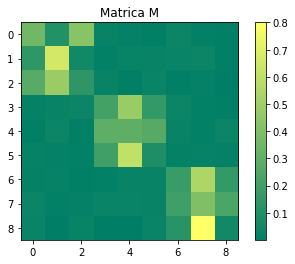

In [ ]:
plt.imshow(M, cmap=plt.cm.get_cmap('summer'))
plt.title("Matrica M")
plt.colorbar()
plt.show()

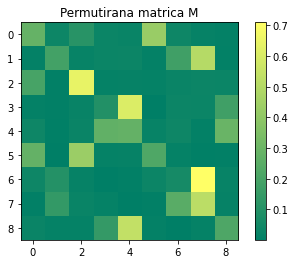

In [ ]:
plt.imshow(M_permutirana, cmap=plt.cm.get_cmap('summer'))        # bez granica
#crtanje_s_granicama(M_permutirana, nM, "summer", "c-")
plt.title("Permutirana matrica M")
plt.colorbar()
plt.show()

In [ ]:
dimenzijaM = len(M_permutirana)
mM,nM,PM=SVD(B=M_permutirana, thr=0.5)
AM=np.dot(np.dot(PM,M_permutirana), np.transpose(PM))
WM=matrica_sparivanja(AM,nM,mM)
#print(f"Matrica B tilda: \n{AM}\n")
print(f"Matrica sparivanja: \n{WM}\n")

Matrica sparivanja: 
[[0.8863 0.0511 0.0626]
 [0.0559 0.8789 0.0652]
 [0.0666 0.0619 0.8715]]



<ipython-input-43-3a7199dd18eb>:34: RuntimeWarning: divide by zero encountered in double_scalars
  norma_1=(B_1.sum().sum())/ind


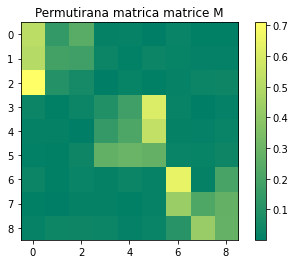

In [ ]:
plt.imshow(AM, cmap=plt.cm.get_cmap('summer'))        # bez granica
#crtanje_s_granicama(M_permutirana, nM, "summer", "c-")
plt.title("Permutirana matrica matrice M")
plt.colorbar()
plt.show()